## This notebook processes the Kang dataset after Kang_Data.ipynb files and generates the graphs and necessary files for subsequent model training.

In [ ]:
import scanpy as sc 
import pandas as pd
import SEACells
import numpy as np
import matplotlib
from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

# Input Data Directory
data_path = "../Cell-Type-Specific-Graphs/Data/"
# Output Results Directory
save_path_results = "../Cell-Type-Specific-Graphs/Results/"

## Import the data

In [2]:
adata = sc.read(data_path+'Kang.h5ad')
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cov_cond', 'SEACell'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Constructing cell type graphs over control cells 

In [3]:
ctrl_data = adata[adata.obs.condition == 'control'].copy()
ctrl_data.obs.cell_type.value_counts()

cell_type
CD4 T cells          5242
CD14+ Monocytes      2828
B cells              1329
CD8 T cells          1096
NK cells              933
FCGR3A+ Monocytes     753
Dendritic cells       207
Name: count, dtype: int64

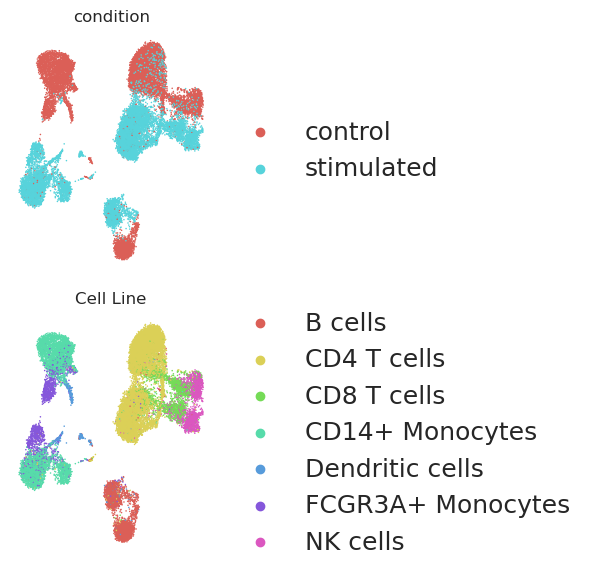

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

fig, axes = plt.subplots(nrows=2, figsize=(6, 6))

# Plot UMAP colored by condition — remove title
sc.pl.umap(
    adata=adata,
    color=["condition"],
    legend_fontsize=18,
    ax=axes[0],
    title=None,  # Remove title
    show=False,
    palette=sns.color_palette("hls", 2),
    frameon=False
)

# Plot UMAP colored by cell type with font size 16
sc.pl.umap(
    adata=adata,
    color=["cell_type"],
    legend_fontsize=18,
    ax=axes[1],
    title="Cell Line",  # Optional: keep or remove
    show=False,
    palette=sns.color_palette("hls", len(adata.obs['cell_type'].unique())),
    frameon=False
)

# Apply font size 16 to axis tick labels manually (optional enhancement)
for ax in axes:
    ax.tick_params(labelsize=16)

# Adjust spacing and save
plt.tight_layout()
plt.savefig("Kang_umap.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [6]:
ctrl_data.obs.cell_type.value_counts()

cell_type
CD4 T cells          5242
CD14+ Monocytes      2828
B cells              1329
CD8 T cells          1096
NK cells              933
FCGR3A+ Monocytes     753
Dendritic cells       207
Name: count, dtype: int64

In [7]:
n_SEACells  = int(len(ctrl_data) / 50)
print(n_SEACells)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

247


## Run SEACells over the control data.

In [8]:
model = SEACells.core.SEACells(ctrl_data, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [9]:
model.construct_kernel_matrix()
M = model.kernel_matrix


Computing kNN graph using scanpy NN ...


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

Computing radius for adaptive bandwidth kernel...


  0%|          | 0/12388 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/12388 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/12388 [00:00<?, ?it/s]

Constructing CSR matrix...


In [10]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 220 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 37/37 [00:00<00:00, 46.15it/s]

Selecting 27 cells from greedy initialization.


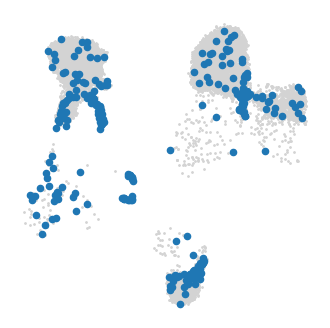

In [11]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ctrl_data, model)

In [12]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00201
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 24 iterations.


In [13]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 25 iterations
Ran for 30 iterations


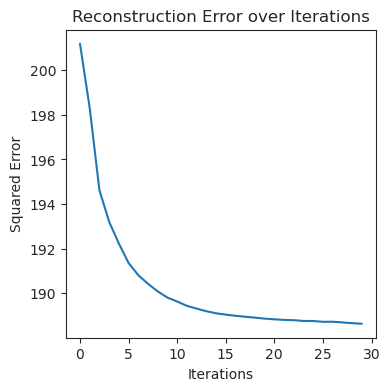

In [14]:
# Check for convergence 
model.plot_convergence()

In [15]:
ctrl_data.obs[['SEACell']].head()
ctrl_data.obs.cell_type

index
AAACATACATTTCC-1        CD14+ Monocytes
AAACATACCAGAAA-1        CD14+ Monocytes
AAACATACCATGCA-1            CD4 T cells
AAACATACCTCGCT-1        CD14+ Monocytes
AAACATACCTGGTA-1        Dendritic cells
                            ...        
TTCTGATGTCTCGC-1-1          CD4 T cells
TTGGAGTGCTCGAA-1-1          CD4 T cells
TTTAGCTGCGAACT-1-1          CD4 T cells
TTTATCCTGCGAGA-1-1    FCGR3A+ Monocytes
TTTATCCTGGAAAT-1-1      CD14+ Monocytes
Name: cell_type, Length: 12388, dtype: category
Categories (7, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells']

In [16]:
adata.obs['SEACell'] = 'None'
adata.obs.loc[ctrl_data.obs.index.tolist(), 'SEACell'] = ctrl_data.obs['SEACell'].values

In [17]:
ctrl_data.layers['X'] = ctrl_data.X

## Summarize SEACells by cell type label

In [18]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ctrl_data,  model.A_, 
                                                          celltype_label='cell_type', summarize_layer = 'counts', minimum_weight = 0.05)
SEACell_soft_ad.X.A

100%|██████████| 247/247 [01:31<00:00,  2.70it/s]


array([[0.        , 0.08952168, 0.08065863, ..., 0.00897379, 0.00812176,
        0.04027151],
       [0.        , 0.07059816, 0.        , ..., 0.0243386 , 0.        ,
        0.27022978],
       [0.        , 0.02022519, 0.        , ..., 0.0340822 , 0.        ,
        0.30215922],
       ...,
       [0.        , 0.06774619, 0.01049788, ..., 0.00319715, 0.01323078,
        0.12723514],
       [0.        , 0.01156454, 0.        , ..., 0.00798367, 0.05754313,
        0.13454265],
       [0.        , 0.02660869, 0.01423437, ..., 0.0122528 , 0.00773031,
        0.26963306]])

In [22]:
SEACell_soft_ad.obs

,Pseudo-sizes,cell_type,celltype_purity
0,20.557071,CD4 T cells,0.970335
1,39.142923,CD14+ Monocytes,0.962128
2,41.643762,CD14+ Monocytes,0.945884
3,36.885068,B cells,0.994675
4,34.870877,FCGR3A+ Monocytes,1.000000
...,...,...,...
242,52.863113,CD14+ Monocytes,0.712264
243,68.056182,CD4 T cells,0.991369
244,56.204450,CD8 T cells,0.774534
245,18.745740,CD4 T cells,0.650686


In [23]:
SEACell_soft_ad.obs
SEACell_soft_ad.obs.rename({"celltype": "cell_type"}, axis=1, inplace=True)

In [24]:
SEACell_soft_ad.obs.cell_type.value_counts()

cell_type
CD4 T cells          82
CD14+ Monocytes      62
B cells              41
FCGR3A+ Monocytes    18
CD8 T cells          16
Dendritic cells      15
NK cells             13
Name: count, dtype: int64

In [25]:
SEACell_soft_ad.write(data_path+'SEACell_soft_ad_Kang.h5ad')

In [26]:
adata.write(data_path+'Kang.h5ad')

In [3]:
SEACell_soft_ad = sc.read(data_path+'SEACell_soft_ad_Kang.h5ad')
SEACell_soft_ad

AnnData object with n_obs × n_vars = 247 × 5000
    obs: 'Pseudo-sizes', 'cell_type', 'celltype_purity'

In [4]:
SEACell_soft_ad.obs.cell_type.value_counts()

cell_type
CD4 T cells          82
CD14+ Monocytes      62
B cells              41
FCGR3A+ Monocytes    18
CD8 T cells          16
Dendritic cells      15
NK cells             13
Name: count, dtype: int64

## Construct co-expression graphs using SEACells generated from the control data.

In [5]:
import os
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import mean_squared_error
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, HeteroData, Batch
from torch_geometric.utils import *
import torch
from torch import nn
cell_type_network = {}
# Leaf directory 
directory = "Kang"
# Parent Directories 
parent_dir = "/ibex/scratch/alsulara/PrePR-CT/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in SEACell_soft_ad.obs.cell_type.unique():
    print(cell_type)
    cell = Correlation_matrix(SEACell_soft_ad, cell_type, 'cell_type',
                       hv_genes_cells = None, union_HVGs = True)
    threshold = np.percentile(np.abs(cell[0].values), 99.0)
    print("threshold:", threshold)
    g = create_coexpression_graph(SEACell_soft_ad, cell, cell_type, threshold, 'gene_name')
    if g.num_nodes >= max_nodes:
        max_nodes = g.num_nodes
    cell_type_network[cell_type] = g
    genes_pos.append(cell_type_network[cell_type].pos)
    cell_type_network[cell_type].pos = torch.tensor(cell_type_network[cell_type].pos)
    torch.save(cell_type_network[cell_type] , os.path.join(path,cell_type+'_coexpr_graph.pkl'))
cell_type_network    

/ibex/scratch/alsulara/PrePR-CT/graphs/Kang
File exists!
CD4 T cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.5634505553703245
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  245430
final number_of_edges:  245430
CD14+ Monocytes


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.5839748586295153
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250000
number_of_edges after removing self loops:  246140
final number_of_edges:  246140
B cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.6780449190883665
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  246080
final number_of_edges:  246080
FCGR3A+ Monocytes


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.5962882018484306
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  246726
final number_of_edges:  246726
Dendritic cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7113680830554484
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250025
number_of_edges after removing self loops:  246781
final number_of_edges:  246781
CD8 T cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.6924911065570157
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250001
number_of_edges after removing self loops:  246056
final number_of_edges:  246056
NK cells


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7713207821754224
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250000
number_of_edges after removing self loops:  246186
final number_of_edges:  246186


{'CD4 T cells': Data(x=[3879, 82], edge_index=[2, 245430], edge_attr=[245430], pos=[3879]),
 'CD14+ Monocytes': Data(x=[3401, 62], edge_index=[2, 246140], edge_attr=[246140], pos=[3401]),
 'B cells': Data(x=[3176, 41], edge_index=[2, 246080], edge_attr=[246080], pos=[3176]),
 'FCGR3A+ Monocytes': Data(x=[3275, 18], edge_index=[2, 246726], edge_attr=[246726], pos=[3275]),
 'Dendritic cells': Data(x=[3234, 15], edge_index=[2, 246781], edge_attr=[246781], pos=[3234]),
 'CD8 T cells': Data(x=[3943, 16], edge_index=[2, 246056], edge_attr=[246056], pos=[3943]),
 'NK cells': Data(x=[3801, 13], edge_index=[2, 246186], edge_attr=[246186], pos=[3801])}

## Check the overlapping genes between the cell type graphs

In [6]:
overlap_df = pd.DataFrame(index = cell_type_network.keys(), columns = cell_type_network.keys())
for key1 in cell_type_network.keys():
    for key2 in cell_type_network.keys():
        overlap_df.loc[key1, key2] = (len(np.intersect1d(cell_type_network[key1].pos, cell_type_network[key2].pos)))

# identify the furthest cell type
indices = np.argsort(overlap_df.values, axis=0)[-7, :]
print(indices)
testing_cell = overlap_df.columns[mode(indices)]
print(testing_cell)
overlap_df

[2 2 4 2 2 2 2]
B cells


,CD4 T cells,CD14+ Monocytes,B cells,FCGR3A+ Monocytes,Dendritic cells,CD8 T cells,NK cells
CD4 T cells,3879,2783,2577,2673,2644,3177,3050
CD14+ Monocytes,2783,3401,2502,2766,2732,3101,3034
B cells,2577,2502,3176,2505,2462,2837,2770
FCGR3A+ Monocytes,2673,2766,2505,3275,2915,3150,3116
Dendritic cells,2644,2732,2462,2915,3234,3116,3103
CD8 T cells,3177,3101,2837,3150,3116,3943,3630
NK cells,3050,3034,2770,3116,3103,3630,3801


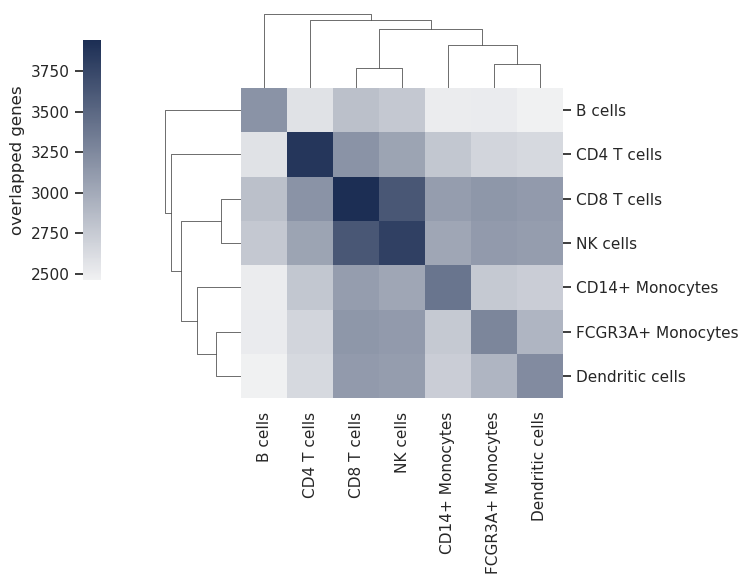

In [8]:
from matplotlib.colors import LinearSegmentedColormap
sns.set()
sns.set_style( {'axes.grid' : False})
import seaborn as sns
cmap = sns.light_palette("#1C2E54", as_cmap=True)
g = sns.clustermap(overlap_df.astype(float), figsize=(6, 6), cmap = cmap
                   , cbar_kws={'label': 'overlapped genes', 'location': 'left'})
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((-0.1, .52, .03, .4))
plt.savefig(save_path_results+'overlap_matrix_Kang.pdf', bbox_inches='tight')
plt.show()
sns.set()

In [4]:
adata = sc.read(data_path+'Kang.h5ad')
adata.obs["dose_value"] = 1.0
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cov_cond', 'SEACell', 'dose_value', 'cov_drug'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
print(len(adata.obs.loc[adata.obs.condition == 'control']), len(adata.obs.loc[adata.obs.condition != 'control']))
print(len(adata.obs.loc[adata.obs.condition == 'control']) + len(adata.obs.loc[adata.obs.condition != 'control']))

12388 11861
24249


In [7]:
import os
cell_type_network = {}
# Leaf directory 
directory = "Kang"
# Parent Directories 
parent_dir = "/ibex/user/alsulara/PrePR-CT/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in adata.obs.cell_type.unique():
    print(cell_type)
    cell_type_network[cell_type] = torch.load(os.path.join(path,cell_type+'_coexpr_graph.pkl'))
    if cell_type_network[cell_type].num_nodes >= max_nodes:
        max_nodes = cell_type_network[cell_type].num_nodes
print(max_nodes)
cell_type_network

/ibex/user/alsulara/PrePR-CT/graphs/Kang
File exists!
CD14+ Monocytes
CD4 T cells
Dendritic cells
NK cells
CD8 T cells
B cells
FCGR3A+ Monocytes
3943


{'CD14+ Monocytes': Data(x=[3401, 62], edge_index=[2, 246140], edge_attr=[246140], pos=[3401]),
 'CD4 T cells': Data(x=[3879, 82], edge_index=[2, 245430], edge_attr=[245430], pos=[3879]),
 'Dendritic cells': Data(x=[3234, 15], edge_index=[2, 246781], edge_attr=[246781], pos=[3234]),
 'NK cells': Data(x=[3801, 13], edge_index=[2, 246186], edge_attr=[246186], pos=[3801]),
 'CD8 T cells': Data(x=[3943, 16], edge_index=[2, 246056], edge_attr=[246056], pos=[3943]),
 'B cells': Data(x=[3176, 41], edge_index=[2, 246080], edge_attr=[246080], pos=[3176]),
 'FCGR3A+ Monocytes': Data(x=[3275, 18], edge_index=[2, 246726], edge_attr=[246726], pos=[3275])}

## Match treatment and control cells using SEACell clusters

In [8]:
stim_data = adata[adata.obs.condition != 'control'].copy()
stim_data.layers['ctrl_x'] = stim_data.X.A
ctrl_data = adata[adata.obs.condition == 'control'].copy()

for cell_type in adata.obs.cell_type.unique():
    genes = cell_type_network[cell_type].pos.tolist()
    cell_type_network[cell_type].x = torch.mean(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    std = torch.var(torch.tensor(ctrl_data[ctrl_data.obs.cell_type == cell_type, genes].copy().X.A), dim = 0)
    cell_type_network[cell_type].x = torch.cat([cell_type_network[cell_type].x.unsqueeze(1), std.unsqueeze(1)], dim = 1)    


for cov_drug in tq.tqdm(stim_data.obs.cov_drug.unique()):
    cell_type = cov_drug.split('_')[0]
    ad_ctrl = ctrl_data[ctrl_data.obs.cell_type == cell_type].copy()
    ad_stim = stim_data[stim_data.obs.cov_drug == cov_drug].copy()
    num_samples = len(ad_stim)
    sele_samples = balance_subsample(np.array(ad_ctrl.obs.index.values.tolist()), np.array(ad_ctrl.obs.SEACell.values.tolist()), num_samples)
    stim_data[ ad_stim.obs.index.values,: ].layers['ctrl_x'] = ad_ctrl[sele_samples, :].copy().X.A

  0%|          | 0/7 [00:00<?, ?it/s]

## Construct PyTorch Geometric (PyG) data objects for the cells to enable GNN training.

In [9]:
from importlib import reload
import utils
reload(utils)
from utils import *
cells_train = create_cells(stim_data, cell_type_network, None)

['CD8 T cells', 'Dendritic cells', 'B cells', 'CD4 T cells', 'CD14+ Monocytes', 'NK cells', 'FCGR3A+ Monocytes']
Categories (7, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells'] ['stimulated']
Categories (1, object): ['stimulated']


Processing cov_drugs:   0%|          | 0/7 [00:00<?, ?it/s]

Processing CD8 T cells_stimulated samples:   0%|          | 0/937 [00:00<?, ?it/s]

Processing Dendritic cells_stimulated samples:   0%|          | 0/224 [00:00<?, ?it/s]

Processing B cells_stimulated samples:   0%|          | 0/1230 [00:00<?, ?it/s]

Processing CD4 T cells_stimulated samples:   0%|          | 0/5087 [00:00<?, ?it/s]

Processing CD14+ Monocytes_stimulated samples:   0%|          | 0/2512 [00:00<?, ?it/s]

Processing NK cells_stimulated samples:   0%|          | 0/1046 [00:00<?, ?it/s]

Processing FCGR3A+ Monocytes_stimulated samples:   0%|          | 0/825 [00:00<?, ?it/s]

In [10]:
import pickle
with open(data_path+'cells_Kang.pkl', 'wb') as f:
    pickle.dump(cells_train, f)

In [12]:
adata.write(data_path+'Kang.h5ad')
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cov_cond', 'SEACell', 'dose_value', 'cov_drug'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'